# Time Series Analysis Coursework
Author: Kars Knook

In [1]:
import numpy as np
import time
from numba import jit
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import scipy as sp

## Question 1

$\color{blue}{\textbf{1a}}$

The spectral density function of an ARMA(p, q) process is:
$$S_X(f) = \sigma_\epsilon^2 \frac{|1-\theta_{1,q}e^{-2i\pi f}- \dots - \theta_{q,q}e^{-2i\pi fq}|^2}{|1-\phi_{1,q}e^{-2i\pi f}- \dots - \phi_{q,q}e^{-2i\pi fp}|^2}$$ 
(page 52 of the notes). Code implementation:

In [2]:
def S_ARMA(f, phis, thetas, sigma2):
    p = len(phis)
    q = len(thetas)
    sdf = np.zeros(len(f)) #initialise spectral density output array
    
    for i in range(len(f)): #for every frequency
        numerator = abs(1 - np.dot(thetas, np.exp(-2j*np.pi*f[i]*np.arange(1, q+1)))) #evaluate numerator
        denominator = abs(1 - np.dot(phis, np.exp(-2j*np.pi*f[i]*np.arange(1, p+1)))) #evaluate denominator
        sdf[i] = sigma2*(numerator/denominator)**2 #store value in array
    return sdf

$\color{blue}{\textbf{1b}}$

In [3]:
def ARMA22_sim(phis, thetas, sigma2, N):
    X = np.zeros(N+100) #initalise simulation array
    e = np.random.normal(0, np.sqrt(sigma2), N+100) #simulate N+100 random normal values
    
    for i in range(2, N+100): #iteratively update X with new simulated values
        X[i] = phis[0]*X[i-1] + phis[1]*X[i-2] + e[i] - thetas[0]*e[i-1] - thetas[1]*e[i-2]
    return X[100:] #only output N last values

$\color{blue}{\textbf{1c}}$

The periodogram is defined as:
$$\hat{S}^{(p)}(f) = \frac{1}{N} \left | \sum_{t=1}^N X_t e^{-i2\pi ft} \right |^2$$ 
(page 58 of the notes). The sum can be computed by using FFT. Code implementation:

In [4]:
def periodogram(X):
    return abs(np.fft.fft(X))**2/len(X)

The $p \times 100$% cosine taper is defined as:
$$h_t = \begin{cases}
\frac{C}{2}(1-cos(\frac{2\pi t}{\lfloor pN \rfloor+1})) & 1 \leq t \leq \frac{\lfloor pN \rfloor}{2} \\
C &  \frac{\lfloor pN \rfloor}{2} < t < N + 1 - \frac{\lfloor pN \rfloor}{2}\\
\frac{C}{2}(1-cos(\frac{2\pi (N+1-t)}{\lfloor pN \rfloor+1})) & N +1 - \frac{\lfloor pN \rfloor}{2} \leq t \leq N
\end{cases}$$
$\newline$
where C is a normalizing constant such that $\sum_{t=1}^N h_t^2 = 1$ (page 64 of the notes). We choose to define function h(t, p, N) and C(p, N) seperately from our direct(X, p) function. Code implementation:

In [5]:
def h(t, p, N): #calculates our unnormalised h's
    boundary = np.floor(p*N)
    if t <= boundary/2:
        return (1 - np.cos(2*np.pi*t/(boundary+1)))/2
    if t < (N + 1 - boundary/2):
        return 1
    else:
        return (1 - np.cos(2*np.pi*(N+1-t)/(boundary+1)))/2

def C(p, N): #calculates normalising constant
    return 1/np.sqrt(sum([h(t, p, N)**2 for t in np.arange(1, N+1)]))

def direct(X, p):
    N = len(X)
    C_ = C(p, N) #find normalising constant
    h_ = np.array([h(t, p, N) for t in range(1, N+1)]) #find h's
    X_tapered = C_*h_*X #calculate tapered time series
    return abs(np.fft.fft(X_tapered))**2 #apply FFT to tapered time series

Note that in the direct(X, p) algorithm we do not divide our result by $N$ because our time series is normalised by tapering.

$\color{blue}{\textbf{1d}}$

Before we do any large computations we would like to optimise our functions. We optimise ARMA22_SIM by introducing another variable $n$: the amount of simulations of length $N$. Now we can start working using matrices and vectorised operations which is much faster. The periodogram(X) function gets another input $freq$ since we are only interested in three frequencies we can filter our results earlier on for these frequencies and avoid unneccesary computations. This is the same for the direct(X, p) function. For this function we also get rid of the $p$ variable and only feed in tapered time series. This will show to be more efficient.

In [6]:
@jit(nopython=True) #function sped up using numba
def ARMA22_sim_optimised(phis, thetas, sigma2, N, n):
    X = np.zeros((n, N+100))
    e = np.random.normal(0, np.sqrt(sigma2), (n, N+100))
    
    for i in range(2, N+100): #vectorised version
        X[:, i] = phis[0]*X[:, i-1] + phis[1]*X[:, i-2] + e[:, i] - thetas[0]*e[:, i-1] - thetas[1]*e[:, i-2]
    return X[:, 100:]

def periodogram_optimised(X, freq):
    return abs(np.fft.fft(X)[:, freq])**2/len(X[0, :]) #note the vectorisation and filtering on frequency

def direct_optimised(X_tapered, freq):
    return abs(np.fft.fft(X_tapered)[:, freq])**2 #note the vectorisation and filtering on frequency

$\color{blue}{\textbf{Part A}}$

From page 51 of the notes we know $z_1 = \frac{1}{a}$ and $z_2 = \frac{1}{b}$. Also $\phi_{1,2} = a+b$ and $\phi_{2,2}=-ab$. So:
$\newline$
$$\phi_{1,2} = r(e^{-i2\pi \frac{12}{128}}+ e^{i2\pi \frac{12}{128}}) = 2r\cos(\frac{24\pi}{128}) \qquad \phi_{1,2} = -r^2$$

In [7]:
#initializing variables
r = 0.8
thetas = np.array([-0.5, -0.2])
phis = np.array([2*r*np.cos(24*np.pi/128), -r**2])
sigma2 = 1
N = 128
results = np.zeros(150000)
p_list = [0.05, 0.1, 0.25, 0.5]
freq = np.array([11, 31, 59])
C_array = np.array([C(p, N) for p in p_list]) #calculating 4 different normalising constants
h_array = np.array([[h(t, p, N) for t in range(1, N+1)] for p in p_list]) #calculating 4 different h-sequences.

t1 = time.time() #time before

X = ARMA22_sim_optimised(phis, thetas, sigma2, N, 10000) #getting 10000 simulations

#calculating periodogram for every simulation and filtering for the right frequencies
results[0:30000] = periodogram_optimised(X, freq).reshape((1, 30000))
#calculating direct spectral estimate per p for every simulation and filtering for the right frequencies
#note that the input time series is tapered
results[30000:60000] = direct_optimised(C_array[0]*h_array[0,:]*X, freq).reshape((1, 30000))
results[60000:90000] = direct_optimised(C_array[1]*h_array[1,:]*X, freq).reshape((1, 30000))
results[90000:120000] = direct_optimised(C_array[2]*h_array[2,:]*X, freq).reshape((1, 30000))
results[120000:150000] = direct_optimised(C_array[3]*h_array[3,:]*X, freq).reshape((1, 30000))

t2 = time.time() #time after
print(t2-t1) #printing delta time

0.563460111618042


As you can see the code is absolutely rapid because of our optimised functions.

$\color{blue}{\textbf{Part B}}$

In [8]:
f = np.array([12/128, 32/128, 60/128]) #initialising frequencies
theoretical_densities = S_ARMA(f, phis, thetas, sigma2) #calculating theoretical spectral densities
results = results.reshape((5, 10000, 3)) #reshaping results
empirical_densities = np.mean(results, axis=1) #averaging results over the 10000 simulations
sample_bias = np.repeat(theoretical_densities, 5).reshape((3,5)).T - empirical_densities #calculating sample bias

index = ["Periodogram", "p = 0.05", "p = 0.1", "p = 0.25", "p = 0.5"]
columns = ["12/128", "32/128", "60/128"]
#setting up data frames
theoretical_densities_df = pd.DataFrame(data=theoretical_densities.reshape((1,3)), index=["Density"], columns=columns)
empirical_densities_df = pd.DataFrame(data=empirical_densities, index=index, columns=columns)
sample_bias_df = pd.DataFrame(data=sample_bias, index=index, columns=columns)

#printing data frames
print("Theoretical densities:")
print(tabulate(theoretical_densities_df, headers='keys', tablefmt='psql'))
print("Empirical densities:")
print(tabulate(empirical_densities_df, headers='keys', tablefmt='psql'))
print("Sample bias:")
print(tabulate(sample_bias_df, headers='keys', tablefmt='psql'))

Theoretical densities:
+---------+----------+----------+-----------+
|         |   12/128 |   32/128 |    60/128 |
|---------+----------+----------+-----------|
| Density |  59.3758 |  0.46856 | 0.0558465 |
+---------+----------+----------+-----------+
Empirical densities:
+-------------+----------+----------+-----------+
|             |   12/128 |   32/128 |    60/128 |
|-------------+----------+----------+-----------|
| Periodogram |  60.9132 | 0.693572 | 0.106057  |
| p = 0.05    |  61.1767 | 0.615584 | 0.0561191 |
| p = 0.1     |  61.3299 | 0.575138 | 0.0555108 |
| p = 0.25    |  61.4825 | 0.558821 | 0.0555787 |
| p = 0.5     |  61.5682 | 0.558855 | 0.0558672 |
+-------------+----------+----------+-----------+
Sample bias:
+-------------+----------+------------+--------------+
|             |   12/128 |     32/128 |       60/128 |
|-------------+----------+------------+--------------|
| Periodogram | -1.5374  | -0.225011  | -0.0502105   |
| p = 0.05    | -1.80084 | -0.147023  | -0.

$\color{blue}{\textbf{Part C}}$

In [9]:
#initalizing variables
r_array = np.arange(0.8, 1, 0.01)
results1 = np.zeros((len(r_array), 150000))

t1 = time.time() #time before

for i, r in enumerate(r_array): #looping over the r's
    phis = np.array([2*r*np.cos(24*np.pi/128), -r**2]) #calculating phis
    #repeating same computations as in part A
    X = ARMA22_sim_optimised(phis, thetas, sigma2, N, 10000)
    results1[i, 0:30000] = periodogram_optimised(X, freq).reshape((1, 30000))
    results1[i, 30000:60000] = direct_optimised(C_array[0]*h_array[0,:]*X, freq).reshape((1, 30000))
    results1[i, 60000:90000] = direct_optimised(C_array[1]*h_array[1,:]*X, freq).reshape((1, 30000))
    results1[i, 90000:120000] = direct_optimised(C_array[2]*h_array[2,:]*X, freq).reshape((1, 30000))
    results1[i, 120000:150000] = direct_optimised(C_array[3]*h_array[3,:]*X, freq).reshape((1, 30000))

t2 = time.time() #time after
print(t2-t1) #printing delta time

2.211482048034668


Again the code is very quick. Now calculating the sample bias:

In [10]:
results1 = results1.reshape((20, 5, 10000, 3)) #reshaping results array
empirical_densities1 = np.mean(results1, axis=2) #taking the mean over the amount of simulations
sample_bias1 = np.zeros((20, 5, 3)) #intializing 

for i in range(20): #calculating sample bias 
    sample_bias1[i, :, :] = np.repeat(theoretical_densities, 5).reshape((3,5)).T - empirical_densities1[i, :, :]

It is hard to plot all these sample biases in one table. We can investigate the first slice which is for $r=0.8$ which should be similar to the result in part B:

In [11]:
sample_bias1[0, :, :]

array([[-1.64501010e+00, -2.31899621e-01, -5.24112187e-02],
       [-1.88226233e+00, -1.54062086e-01, -1.26445437e-03],
       [-2.02979316e+00, -1.10784501e-01, -5.38637057e-04],
       [-2.37270958e+00, -9.31063095e-02, -2.41746959e-04],
       [-2.57846923e+00, -8.90430057e-02, -2.13193708e-04]])

Indeed the results are similar!

$\color{blue}{\textbf{Part D}}$

In [12]:
#initializing
f1 = np.zeros((5,20))
f2 = np.zeros((5,20))
f3 = np.zeros((5,20))
theoretical_densities1 = np.zeros((3, 20)) #r (x-axis of array) and frequency (y-axis of array)

for i, r in enumerate(r_array): #loopover the r's
    results_per_r = results1[i, :] #fetch the right values per r
    results_per_r = results_per_r.reshape((5, 10000, 3)) #reshape
    results_per_r = np.mean(results_per_r, axis=1) #take the mean   
    #store averages per frequency
    f1[:, i] = results_per_r[:, 0] #r (x-axis of array) and method (y-axis of array)
    f2[:, i] = results_per_r[:, 1]
    f3[:, i] = results_per_r[:, 2]
    #calculate theoretical densities per r
    phis = np.array([2*r*np.cos(24*np.pi/128), -r**2])
    theoretical_densities1[:, i] = S_ARMA(f, phis, thetas, sigma2)

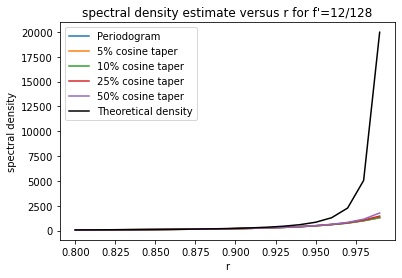

In [13]:
#plotting for f = 12/128
plt.plot(r_array, f1[0, :])
plt.plot(r_array, f1[1, :])
plt.plot(r_array, f1[2, :])
plt.plot(r_array, f1[3, :])
plt.plot(r_array, f1[4, :])
plt.plot(r_array, theoretical_densities1[0, :], color='black')
plt.xlabel("r")
plt.ylabel("spectral density")
plt.title("spectral density estimate versus r for f'=12/128")
plt.legend(["Periodogram", "5% cosine taper", "10% cosine taper", "25% cosine taper", "50% cosine taper", "Theoretical density"])

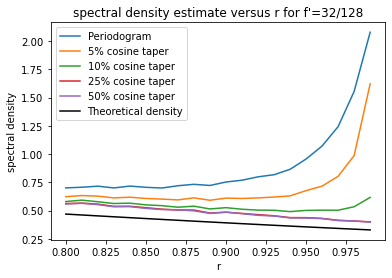

In [14]:
#plotting for f = 30/128
plt.plot(r_array, f2[0, :])
plt.plot(r_array, f2[1, :])
plt.plot(r_array, f2[2, :])
plt.plot(r_array, f2[3, :])
plt.plot(r_array, f2[4, :])
plt.plot(r_array, theoretical_densities1[1, :], color='black')
plt.xlabel("r")
plt.ylabel("spectral density")
plt.title("spectral density estimate versus r for f'=32/128")
plt.legend(["Periodogram", "5% cosine taper", "10% cosine taper", "25% cosine taper", "50% cosine taper", "Theoretical density"])

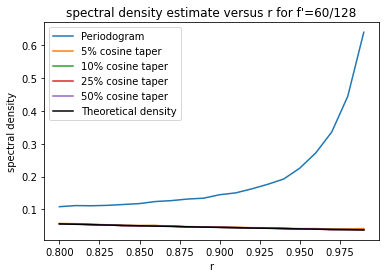

In [15]:
#plotting for f = 60/128
plt.plot(r_array, f3[0, :])
plt.plot(r_array, f3[1, :])
plt.plot(r_array, f3[2, :])
plt.plot(r_array, f3[3, :])
plt.plot(r_array, f3[4, :])
plt.plot(r_array, theoretical_densities1[2, :], color='black')
plt.xlabel("r")
plt.ylabel("spectral density")
plt.title("spectral density estimate versus r for f'=60/128")
plt.legend(["Periodogram", "5% cosine taper", "10% cosine taper", "25% cosine taper", "50% cosine taper", "Theoretical density"])

Remove periodogram to get a closer look:

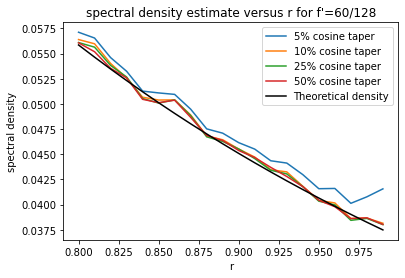

In [16]:
#plotting for f = 60/128 without periodogram
plt.plot(r_array, f3[1, :])
plt.plot(r_array, f3[2, :])
plt.plot(r_array, f3[3, :])
plt.plot(r_array, f3[4, :])
plt.plot(r_array, theoretical_densities1[2, :], color='black')
plt.xlabel("r")
plt.ylabel("spectral density")
plt.title("spectral density estimate versus r for f'=60/128")
plt.legend(["5% cosine taper", "10% cosine taper", "25% cosine taper", "50% cosine taper", "Theoretical density"])

$\color{blue}{\textbf{1e}}$

First plot the spectral density functions and calculate the dynamic range for $p = 0.8, 0.9, 0.99$

The dynamic range is 30.51838109359446


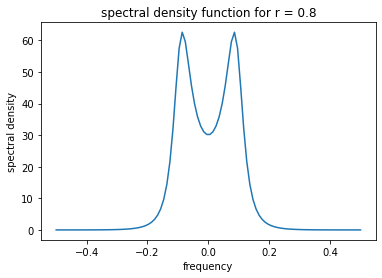

In [17]:
#for r = 0.8
r = 0.8
f = np.linspace(-1/2, 1/2, 100)
phis = phis = np.array([2*r*np.cos(24*np.pi/128), -r**2])
density = S_ARMA(f, phis, thetas, sigma2)

plt.plot(f, density)
plt.title("spectral density function for r = 0.8")
plt.xlabel("frequency")
plt.ylabel("spectral density")
print(f"The dynamic range is {10*np.log10(np.max(density)/np.min(density))}")

The dynamic range is 36.665860400480895


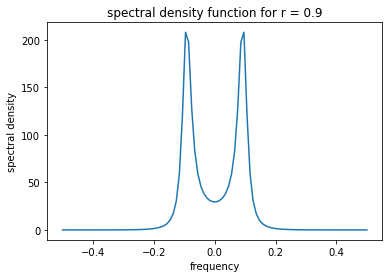

In [18]:
#for r = 0.9
r = 0.9
f = np.linspace(-1/2, 1/2, 100)
phis = phis = np.array([2*r*np.cos(24*np.pi/128), -r**2])
density = S_ARMA(f, phis, thetas, sigma2)

plt.plot(f, density)
plt.title("spectral density function for r = 0.9")
plt.xlabel("frequency")
plt.ylabel("spectral density")
print(f"The dynamic range is {10*np.log10(np.max(density)/np.min(density))}")

The dynamic range is 52.530004577704126


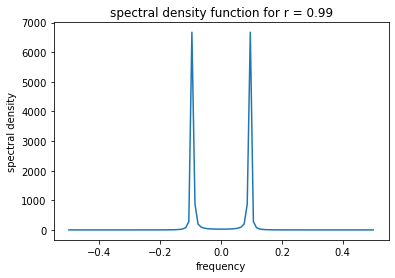

In [19]:
#for r = 0.99
r = 0.99
f = np.linspace(-1/2, 1/2, 100)
phis = phis = np.array([2*r*np.cos(24*np.pi/128), -r**2])
density = S_ARMA(f, phis, thetas, sigma2)

plt.plot(f, density)
plt.title("spectral density function for r = 0.99")
plt.xlabel("frequency")
plt.ylabel("spectral density")
print(f"The dynamic range is {10*np.log10(np.max(density)/np.min(density))}")

As $r$ increases to 1, i.e. the roots of the AR characteristic function move closer to the unit circle, most of the density will move towards the oscillating frequency $f^\prime$. We also note that the dynamic range increases. From the figures in 1D part D we understand that any of the 5 methods gives good estimates for the spectral density at the oscillating frequency given $r$ is small. Similarly for the two frequencies away from the oscillating frequency the tapers give a significantly better estimate for all $r$. Overall it becomes apparent that as $r$ increases, i.e. the dynamic range increases, our estimators become more and more biased

## Question 2

$\color{blue}{\textbf{2a}}$

In [20]:
X = np.genfromtxt('89.csv', delimiter=',')
x = np.linspace(-1/2, 1/2, len(X))

Text(0, 0.5, 'spectral density')

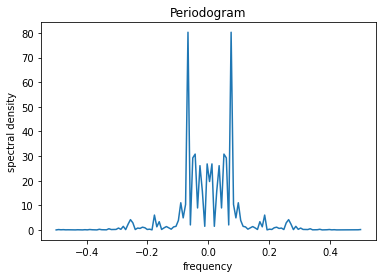

In [21]:
plt.plot(x, periodogram(X))
plt.title("Periodogram")
plt.xlabel("frequency")
plt.ylabel("spectral density")

Text(0, 0.5, 'spectral density')

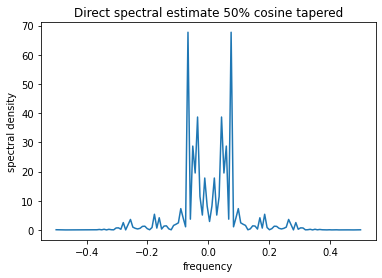

In [22]:
plt.plot(x, direct(X, p=0.5))
plt.title("Direct spectral estimate 50% cosine tapered")
plt.xlabel("frequency")
plt.ylabel("spectral density")

$\color{blue}{\textbf{2b}}$

First we define a function acv(X, tau) that computes $\hat{s}_{\tau}^{(p)}$ according to the definition on page 56 of the notes:

In [23]:
def acv(X, tau):
    N = len(X)
    return sum([X[t]*X[t+abs(tau)] for t in range(N-abs(tau))])/N #time series has mean zero

Yule-Walker as described on page 66 of the notes. Use the Levinson-Durbin method for solving the linear system in the Yule-Walker method:

In [24]:
def yule_walker(X, p):
    gamma = np.array([acv(X, tau) for tau in range(1, p+1)]) #initializing gamma
    phis = sp.linalg.solve_toeplitz([acv(X, tau) for tau in range(p)], gamma) #Levinson Durbin method
    sigma2 = acv(X, 0) - np.dot(phis, gamma) #calculating sigma squared
    return phis, sigma2

Same procedure but now first taper the time series using 50% cosine taper. We can reuse acv(X, tau) but we have to multiply with $N$ to get the right sample autocovariance given on page 67 of the notes. Yule-Walker 50% cosine tapered:

In [25]:
def yule_walker_tapered(X, p):
    N = len(X)
    X_tapered = C_array[3]*h_array[3, :]*X #tapering
    gamma = N*np.array([acv(X_tapered, tau) for tau in range(1, p+1)]).T #initializing gamma but multiplying with N
    phis = sp.linalg.solve_toeplitz([N*acv(X_tapered, tau) for tau in range(p)], gamma) #Levinson Durbin method, multiplying Gamma with N
    sigma2 = N*acv(X_tapered, 0) - np.dot(phis, gamma) #calculating sigma squared
    return phis, sigma2 

Approximate maximum likelihood as described in method 1 on page 72-73 of the notes:

In [26]:
def approx_MLE(X, p):
    N = len(X)
    F = sp.linalg.toeplitz([X[i] for i in range(p-1, N-1)], [X[i] for i in range(p-1, -1, -1)]) #calculating F
    X = np.array([X[i] for i in range(p, N)]).T #calculating X
    phis = np.linalg.solve(F.T@F, F.T@X) #solving for the vector of phis
    sigma2 = np.dot(X - F@phis, X - F@phis)/(N-p) #calculating sigma squared
    return phis, sigma2

$\color{blue}{\textbf{2c}}$

In [27]:
AIC = np.zeros((20, 3)) #initializing
N = len(X)
for p in range(20): #computing the AIC for all AR(p) models found by the three different methods
    AIC[p, 0] = 2*(p+1) + N*np.log(yule_walker(X, p+1)[1])
    AIC[p, 1] = 2*(p+1) + N*np.log(yule_walker_tapered(X, p+1)[1])
    AIC[p, 2] = 2*(p+1) + N*np.log(approx_MLE(X, p+1)[1])

index = [f"{p}" for p in range(1, 21)]
columns = ["Yule-Walker untapered", "Yule-Walker 50% cosine tapered", "Approximate maximum likelihood"]
AIC_df = pd.DataFrame(data=AIC, index=index, columns=columns)

print("AIC per p for different methods:")
print(tabulate(AIC_df, headers='keys', tablefmt='psql'))

AIC per p for different methods:
+----+-------------------------+----------------------------------+----------------------------------+
|    |   Yule-Walker untapered |   Yule-Walker 50% cosine tapered |   Approximate maximum likelihood |
|----+-------------------------+----------------------------------+----------------------------------|
|  1 |                30.535   |                          15.8137 |                          28.5675 |
|  2 |                -1.62559 |                         -14.9756 |                          -7.8517 |
|  3 |                -9.18398 |                         -26.135  |                         -18.5532 |
|  4 |               -40.6504  |                         -67.9091 |                         -65.791  |
|  5 |               -39.1745  |                         -66.2999 |                         -63.3931 |
|  6 |               -37.8487  |                         -65.1318 |                         -60.97   |
|  7 |               -37.1162  |        

$\color{blue}{\textbf{2d}}$

We want the AIC to be the smallest possible per method. For Yule-Walker untapered and tapered the AIC is smallest when $p=4$ and for approximate maximum likelihood when $p=10$. The resulting model coefficients are:

In [28]:
print(yule_walker(X, 4))
print(yule_walker_tapered(X, 4))
print(approx_MLE(X, 10))

(array([-1.52662882, -1.21945802, -0.93878702, -0.47965693]), 0.6838056805005079)
(array([-1.56528992, -1.33147874, -1.06444958, -0.53818345]), 0.5526447012563005)
(array([-1.64159636, -1.54063086, -1.27409892, -0.67874068, -0.05953835,
        0.15946257,  0.2775932 ,  0.26245515,  0.321134  ,  0.23161596]), 0.5053184750771611)


$\color{blue}{\textbf{2e}}$

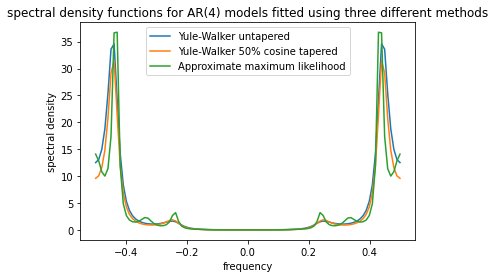

In [29]:
f = np.linspace(-1/2, 1/2, 100)
plt.plot(f, S_ARMA(f, yule_walker(X, 4)[0], [], yule_walker(X, 4)[1]))
plt.plot(f, S_ARMA(f, yule_walker_tapered(X, 4)[0], [], yule_walker_tapered(X, 4)[1]))
plt.plot(f, S_ARMA(f, approx_MLE(X, 10)[0], [], approx_MLE(X, 10)[1]))
plt.xlabel("frequency")
plt.ylabel("spectral density")
plt.title("spectral density functions for AR(4) models fitted using three different methods")
plt.legend(columns)

## Question 3

$\color{blue}{\textbf{3a}}$

First compute the AIC for the $AR(p)$ models ($p = 1,2,\dots, 20$ fitted by the approximate maximum likelihood method for the shortened time series. We select the model with the lowest AIC again:

In [30]:
AIC = np.zeros(20)
for p in range(20):
    AIC[p] = 2*(p+1) + 118*np.log(approx_MLE(X[:118], p+1)[1]) #calculating the AIC's

print(f"Best p = {np.argmin(AIC)+1}") #finding the best p based on the AIC's

Best p = 10


So we choose the $AR(10)$ model fitted by the approximated maximum likelihood method. Next we forecast another 10 values and setting future innovation terms to 0, i.e. there is no randomness.

Actual values and forecasted values per t:
+-----+----------------+--------------------+
|     |   Actual value |   Forecasted value |
|-----+----------------+--------------------|
| 119 |      -2.7271   |          -2.54784  |
| 120 |       0.31665  |           0.52142  |
| 121 |       0.41046  |           1.54648  |
| 122 |       0.14408  |          -2.61869  |
| 123 |       0.92128  |           4.94897  |
| 124 |      -2.2063   |          -5.87435  |
| 125 |       1.283    |           2.36574  |
| 126 |       0.011841 |          -1.27907  |
| 127 |       0.18538  |          -0.509665 |
| 128 |      -1.7523   |           0.944601 |
+-----+----------------+--------------------+


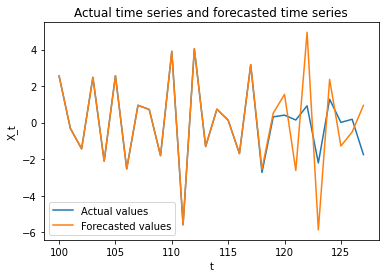

In [31]:
X_ = X.copy()
phis = approx_MLE(X[:118], 10)[0] #fetching the model coefficients phi

for i in range(118, 128):
    X_[i] = np.dot(phis, X_[i-11:i-1]) #forecasting step

x = np.arange(100, 128)

plt.plot(x, X[100:128])
plt.plot(x, X_[100:128])
plt.xlabel("t")
plt.ylabel("X_t")
plt.title("Actual time series and forecasted time series")
plt.legend(["Actual values", "Forecasted values"])

forecast = np.zeros((10, 2))
forecast[:, 0] = X[118:128]
forecast[:, 1] = X_[118:128]
index = [f"{t}" for t in range(119, 129)]
columns = ["Actual value", "Forecasted value"]
forecast_df = pd.DataFrame(data=forecast, index=index, columns=columns)

print("Actual values and forecasted values per t:")
print(tabulate(forecast_df, headers='keys', tablefmt='psql'))

$\color{blue}{\textbf{3b}}$

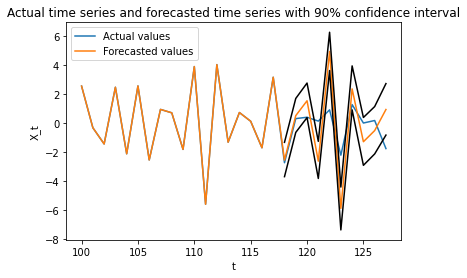

In [32]:
#finding model coefficients
phis = approx_MLE(X[:118], 10)[0]
sigma2 = approx_MLE(X[:118], 10)[1]

trajectories = np.repeat(np.array([X]), [1000], axis=0)
e = np.random.normal(0, np.sqrt(sigma2), (1000, 128))

for i in range(118, 128): #forecasting the trajectoreis
    trajectories[:, i] = np.dot(trajectories[:, i-11:i-1], phis) + e[:, i]
    
trajectories = trajectories[:, 118:]
#intiliazing
upper_bound = np.zeros(10)
lower_bound = np.zeros(10)
for i in range(10): #finding 50th and 950th largest values
    upper_bound[i] = np.partition(trajectories[:, i], -50)[-50]
    lower_bound[i] = np.partition(trajectories[:, i], -950)[-950]
    
x = np.arange(100, 128)

plt.plot(x, X[100:128])
plt.plot(x, X_[100:128])
plt.plot(np.arange(118, 128), upper_bound, color="black")
plt.plot(np.arange(118, 128), lower_bound, color="black")
plt.xlabel("t")
plt.ylabel("X_t")
plt.title("Actual time series and forecasted time series with 90% confidence interval")
plt.legend(["Actual values", "Forecasted values"])